# Анализ товарного ассортимента интернет-магазина товаров для дома и быта «Пока все ещё тут»

## 1 Описание данных

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».
<br>Колонки в ecommerce_dataset.csv :
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

Необходимо проанализировать ассортимент товаров

## 2 Загрузка данных и подготовка их к анализу

### 2.1 Подключение обновлений и библиотек

In [1]:
#Подключим обновления
!pip install plotly
!pip install matplotlib==3.4.3 --user --upgrade
!pip install pandas-datareader --upgrade
!pip install abc_analysis
!pip install abc_analysis --upgrade

In [2]:
#Импортируем библиотеки
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
import seaborn as sns
import plotly.express as px
import math as mth
from pylab import rcParams
from pymystem3 import Mystem
from collections import Counter
from abc_analysis import abc_analysis, abc_plot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from scipy import stats as stat

In [3]:
#Зададим некоторые исходные параметры
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100
rcParams['figure.figsize'] = 14, 10
pd.options.display.float_format = '{:,.3f}'.format
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2.2 Ознакомление с данными

In [4]:
df = pd.read_csv('/datasets/ecommerce_dataset.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.000
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.000
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.000
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.000
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.000


Таблица df содержит 6737 записей и 6 полей:
- `date` - дата заказа (тип int64);
- `customer_id` - идентификатор покупателя (тип object);
- `order_id`-  идентификатор заказа (тип int64);
- `product` - наименование товара (тип object);
- `quantity`- количество товара в заказе (тип int64);
- `price` - цена товара (тип float64)

Тип данных столбца `date` не соответствует, необходимо перевести в формат даты, остальные типы столбцов соответствуют здравому смыслу. Пропусков в данных нет. Наименование столбцов в змеином регистре, что соответствует правилам

### 2.3 Подготовка данных

#### 2.3.1 Корректировка форматов

Переведем дату в требуемый формат. Сформируем новый столбец с месяцем

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['month'] = df['date'].values.astype('datetime64[M]')
df.head()

,date,customer_id,order_id,product,quantity,price,month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.000,2018-10-01
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.000,2018-10-01
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.000,2018-10-01
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.000,2018-10-01
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.000,2018-10-01


In [6]:
print("Дата начала исследования: {}".format(df['month'].min()))

Дата начала исследования: 2018-10-01 00:00:00


In [7]:
print("Дата окончания исследования: {}".format(df['month'].max()))

Дата окончания исследования: 2019-10-01 00:00:00


In [8]:
print("Период исследования составил: {} дней".format(df['month'].max() - df['month'].min()))

Период исследования составил: 365 days 00:00:00 дней


#### 2.3.2 Просмотр уникальных значений

In [9]:
for row in df:
    print(row)
    print(df[row].value_counts(dropna=False).sort_index(ascending=True))
    print('*'*60)

date
2018-10-01 00:00:00    7
2018-10-01 08:00:00    2
2018-10-01 09:00:00    1
2018-10-01 11:00:00    1
2018-10-01 12:00:00    1
                      ..
2019-10-31 11:00:00    2
2019-10-31 12:00:00    1
2019-10-31 13:00:00    1
2019-10-31 14:00:00    1
2019-10-31 16:00:00    1
Name: date, Length: 2606, dtype: int64
************************************************************
customer_id
000d6849-084e-4d9f-ac03-37174eaf60c4    4
001cee7f-0b29-4716-b202-0042213ab038    1
00299f34-5385-4d13-9aea-c80b81658e1b    1
002d4d3a-4a59-406b-86ec-c3314357e498    1
003bbd39-0000-41ff-b7f9-2ddaec152037    1
                                       ..
ff601403-b094-4b86-9ac6-264d725b9277    1
ffaeab76-3a8d-49ee-860f-17273b2fc8a2    3
ffb5976a-7a4d-460b-95c4-5ffaba31cb24    2
ffb80538-3fda-4351-8ea9-9d2bec58bb07    1
ffe82299-3f5b-4214-87fe-3d36ecccfac3    1
Name: customer_id, Length: 2451, dtype: int64
************************************************************
order_id
12624     2
13547    21
14480 

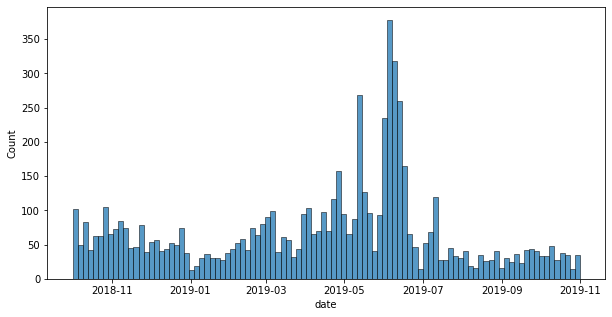

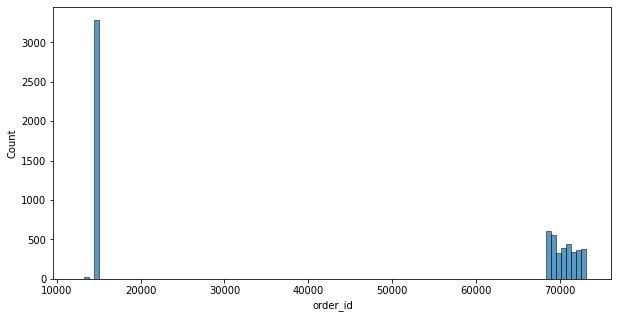

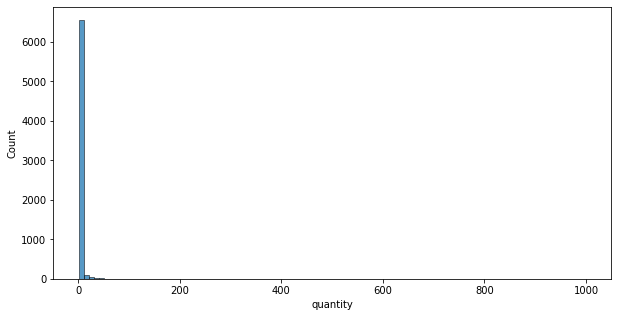

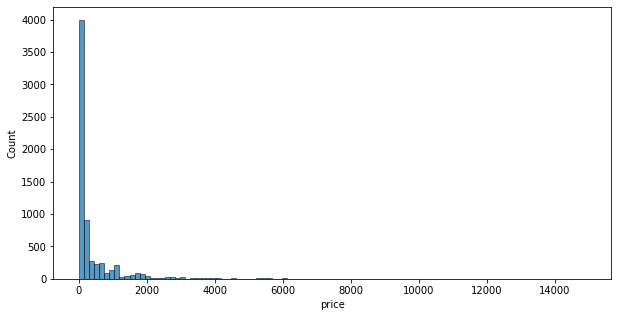

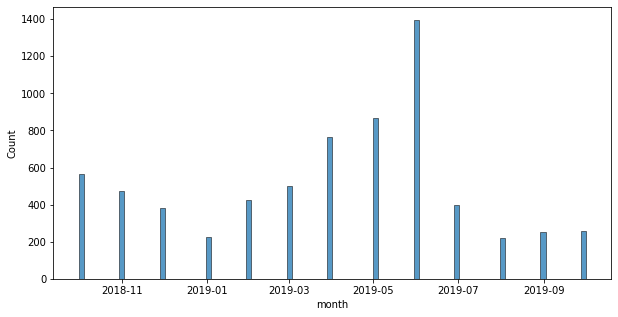

In [10]:
for column in ['date','order_id','quantity','price', 'month']:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[column], bins=100)
    plt.show()

Исходя из гистограмм и уникальных значений можно сделать несколько выводов:
- период, который мы рассматриваем, с 1 октября 2018 года до 1 октября 2019 года (365 дней)
- идентификаторы заказов (order_id) сгруппированы в две группы (в районе 15000 и 70 000), по-видимому это разные группы заказов (по времени или по ассортименту). Ниже рассмотрим ситуацию с идентификаторами заказов более подробно
- количество заказанных товаров варьируется от 1 до 1000 (ниже рассмотрим ситуацию подробнее, поскольку количество 1000 ед приводит к мысли о выбросах)
- цена единицы товара варьируется от 9 до 14 917 ден. ед. (также более подромно рассмотрим ниже)
- максимальное количество покупок было в июне 2019 года

#### 2.3.3 Работа со столбцом `quantity`

<AxesSubplot:>

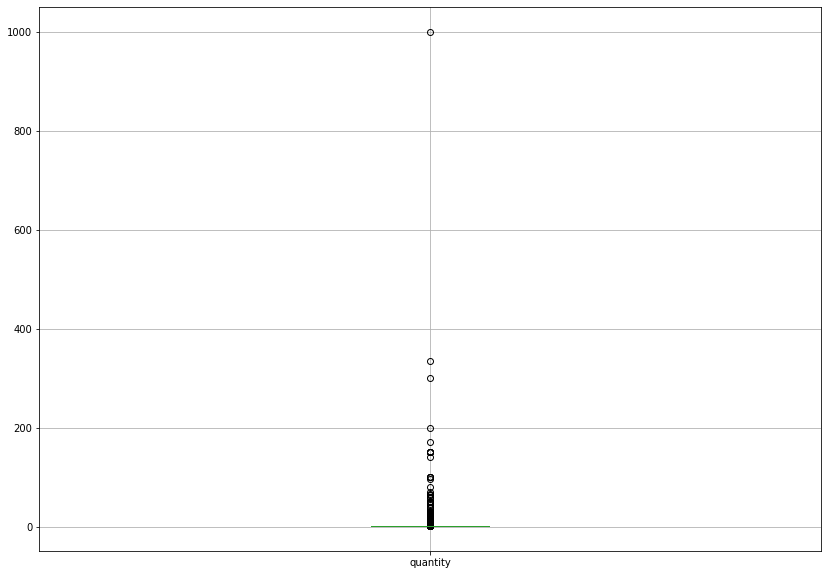

In [11]:
df.boxplot(column='quantity')

In [12]:
df.sort_values('quantity', ascending=False).head(10)

,date,customer_id,order_id,product,quantity,price,month
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.000,2019-06-01
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.000,2019-06-01
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.000,2019-05-01
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.000,2018-12-01
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.000,2018-11-01
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.000,2018-10-01
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,38.000,2018-10-01
267,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,38.000,2018-10-01
2431,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.000,2019-03-01
266,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.000,2018-10-01


In [13]:
max_q = df.loc[(df['quantity'] == 1000) | (df['quantity'] == 300) | (df['quantity'] == 334)]
max_q

,date,customer_id,order_id,product,quantity,price,month
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.000,2019-05-01
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.000,2019-06-01
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.000,2019-06-01


In [14]:
cust_1 = df.loc[(df['customer_id'] == 'cd09ea73-d9ce-48c3-b4c5-018113735e80')]
cust_1

,date,customer_id,order_id,product,quantity,price,month
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.000,2018-10-01
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,38.000,2018-10-01
266,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.000,2018-10-01
267,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,38.000,2018-10-01


In [15]:
cust_2 = df.loc[(df['customer_id'] == '146cd9bf-a95c-4afb-915b-5f6684b17444')]
cust_2

,date,customer_id,order_id,product,quantity,price,month
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.000,2019-06-01


Проведя анализ таблицы, я приняла решение, что записи под номером 5071 и 5456 являются некорректными, так как магазин не специализируется на **крупных оптовых поставках**, и ситуация в которой физическое лицо оформляет заказ на 3 * 334 = 10002 вешалки или 1000 вантузов маловероятна. Но при этом данные заказы очень сильно поднимают среднюю выручку, что может плохо отразится на итоговых выводах
<br>**Запись 3961** - 300 муляжей яблок, оставим, такая ситуация вполне возможна, например, антураж для фотосессий
<br>**Запись 1158** ручка-скоба в размере 200 шт, вероятно мелкооптовая покупка какой-либо фирмы
<br>**Записи 21, 212, 267, 266** совершены одним и тем же покупателем, вероятно фирма по ремонту
<br>Итак, в пункте 2.3.8 (очистка данных) убираем записи 5071 и 5456

#### 2.3.4 Работа со столбцом `price`

In [16]:
max_p = df.loc[df['price']  == 14917]
max_p

,date,customer_id,order_id,product,quantity,price,month
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,"14,917.000",2019-07-01


По данным из интернета сушилка уличная Leifheit может стоить 15 000 и даже более, запись корректна, оставляем ее

#### 2.3.5 Работа со столбцом `order_id`

In [17]:
print(sorted(list(df['order_id'].unique())))

[12624, 13547, 14480, 14481, 14482, 14485, 14486, 14487, 14490, 14494, 14496, 14497, 14498, 14499, 14500, 14501, 14503, 14504, 14505, 14507, 14509, 14510, 14511, 14512, 14513, 14514, 14516, 14521, 14522, 14525, 14526, 14527, 14529, 14530, 14531, 14532, 14534, 14535, 14537, 14538, 14540, 14541, 14542, 14543, 14544, 14545, 14546, 14547, 14548, 14549, 14550, 14552, 14553, 14554, 14555, 14557, 14559, 14560, 14561, 14562, 14563, 14565, 14566, 14567, 14568, 14569, 14570, 14572, 14575, 14578, 14580, 14581, 14588, 14590, 14595, 14596, 14597, 14600, 14601, 14604, 14606, 14608, 14611, 14612, 14614, 14615, 14616, 14617, 14619, 14621, 14623, 14624, 14625, 14626, 14627, 14628, 14629, 14631, 14634, 14637, 14638, 14639, 14640, 14641, 14642, 14644, 14645, 14646, 14649, 14651, 14652, 14653, 14655, 14657, 14663, 14664, 14666, 14668, 14669, 14671, 14673, 14674, 14679, 14680, 14682, 14683, 14685, 14686, 14687, 14688, 14689, 14691, 14693, 14694, 14695, 14696, 14697, 14698, 14700, 14701, 14704, 14705, 14706

Как мы уже увидели выше, на графике в пункте 2.3.2, идентификаторы заказов укладываются в два диапазона: первый - от 12624 до 14946 и второй - от 56879 до 73164

In [18]:
print('Всего за период исследования было сделано {} уникальных заказа'.format(len(df['order_id'].unique())))

Всего за период исследования было сделано 2784 уникальных заказа


In [19]:
order_1 = df.loc[(df['order_id']  == 14946) | (df['order_id']  == 14554) | (df['order_id']  == 13547)]
order_1

,date,customer_id,order_id,product,quantity,price,month
102,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.000,2018-10-01
103,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете по 6 шт,1,207.000,2018-10-01
104,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по 6 шт,1,162.000,2018-10-01
376,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.000,2018-10-01
377,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете по 6 шт,1,207.000,2018-10-01
378,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по 6 шт,1,162.000,2018-10-01
509,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.000,2018-10-01
510,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете по 6 шт,1,207.000,2018-10-01
511,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по 6 шт,1,162.000,2018-10-01
588,2018-11-02 14:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.000,2018-11-01


In [20]:
order_2 = df.loc[(df['order_id']  == 68905) | (df['order_id']  == 69818) | (df['order_id']  == 73164)]
order_2

,date,customer_id,order_id,product,quantity,price,month
690,2018-11-07 15:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68905,"Рыбочистка металлическая, 1216396",3,127.000,2018-11-01
1510,2019-01-14 13:00:00,3b21f626-e3f2-41c0-9b20-614c95bb4fa4,69818,Сушилка для белья напольная НИКА СБ1Г 18 м бело-голубая,1,652.000,2019-01-01
6735,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.000,2019-10-01


При рандомной проверке получили, что в первый диапазон идентификаторов заказа попадают заказы за разные даты разных покупателей садовых растений, в во второй - товары для домашнего хозяйства. Важной информации из этого исследования мы не получили, но можем предположить, что интернет-магазин распределяет идентификаторы по группам в зависимости от типа товара

#### 2.3.6 Работа со столбцом `customer_id`

Определим количество заказов, совершенное каждым покупателем

In [21]:
print(df.groupby('customer_id', as_index=False).agg({'order_id':'nunique'}).sort_values(by='order_id',ascending=False).head(10))

                               customer_id  order_id
1916  c971fb21-d54c-4134-938f-16b62ee86d3b       126
742   4d93d3f6-8b24-403b-a74b-f5173e40d7db        35
1101  73d1cd35-5e5f-4629-8cf2-3fda829d4e58        17
1748  b7b865ab-0735-407f-8d0c-31f74d2806cc         7
17    0184f535-b60a-4914-a982-231e3f615206         5
1820  bea7a833-2074-42db-bc49-4457abd3c930         4
2147  e0535076-6270-4df2-8621-cb06264a94fa         4
699   498f12a4-6a62-4725-8516-cf5dc9ab8a3a         4
1184  7d0641a6-e043-487d-b356-38895fe7df84         3
2307  f163e581-59ba-4022-99db-e0973c7497c0         3


In [22]:
print('В среднем 1 покупатель за весь период совершил {:.2} заказа'.format(len(df['customer_id'].unique())/len(df['order_id'].unique())))

В среднем 1 покупатель за весь период совершил 0.88 заказа


Пользователь `c971fb21-d54c-4134-938f-16b62ee86d3b` совершил аномальное количество заказов - 126 за период
<br>Просмотрим данные заказы

In [23]:
customer_3 = df.loc[(df['customer_id']  == 'c971fb21-d54c-4134-938f-16b62ee86d3b')]
customer_3

,date,customer_id,order_id,product,quantity,price,month
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.000,2018-10-01
20,2018-10-02 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68490,Чехол для гладильной доски Festival 137x60 см из хлопка 4738,1,"1,162.000",2018-10-01
64,2018-10-03 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68511,Набор прищепок большие пластиковые ROZENBAL ПИНОККИО 10 шт R102312,10,86.000,2018-10-01
65,2018-10-03 10:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68514,Сушилка для белья Attribute ПРИМА 11 м синяя напольная ADP410,1,749.000,2018-10-01
130,2018-10-08 07:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68561,Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас...,1,742.000,2018-10-01
...,...,...,...,...,...,...,...
2171,2019-03-04 15:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70582,Нефролепис Бостон d-12 см,1,292.000,2019-03-01
2173,2019-03-04 16:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70589,Калла крупноцветковая желтая,1,374.000,2019-03-01
2191,2019-03-05 13:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70606,Пеларгония розебудная Red Pandora укорененный черенок,1,134.000,2019-03-01
2195,2019-03-05 15:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70614,Гладильная доска НИКА LORA FASHION HLF 123х46 см,1,"1,949.000",2019-03-01


Возможно данный покупатель является так называемым "перекупом", но я не вижу причин удалять его из рассмотрения, поскольку за рассматриваемый период вполне возможно осуществить данное количество заказов

In [24]:
print('За весь период магазин посетило {} уникальных покупателя'.format(len(df['customer_id'].unique())))

За весь период магазин посетило 2451 уникальных покупателя


#### 2.3.7 Просмотр статистических значений

In [25]:
df['quantity'].describe().T

count   6,737.000
mean        2.502
std        15.266
min         1.000
25%         1.000
50%         1.000
75%         1.000
max     1,000.000
Name: quantity, dtype: float64

In [26]:
df['price'].describe().T

count    6,737.000
mean       462.028
std        871.296
min          9.000
25%        101.000
50%        135.000
75%        398.000
max     14,917.000
Name: price, dtype: float64

Среднее значение количества заказанного товара составляет 2,5, медианное - 1 (на такой сильный сдвиг медианы повлияли огромные заказы вантузов и т.д.)
<br>Среднее значение цены единицы товара составило 462,028 ден.ед., медианное - 135 ден. ед. (сдвиг медианы произошел из-за достаточно дорогого товара ценой в 14 917 руб.

#### 2.3.8 Поиск дубликатов

Сначала просмотрим явные дубликаты

In [27]:
print('В таблице явных дубликатов:', df.duplicated().sum())

В таблице явных дубликатов: 0


Явных дубликатов нет, проверим дубликаты по совпадению столбцов `customer_id`, `order_id`, `product`,`quantity`,`price`

In [28]:
dubl=df.loc[df.duplicated(subset=['customer_id', 'order_id', 'product','quantity','price'], keep=False)]
dubl

,date,customer_id,order_id,product,quantity,price,month
15,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Мини-сковорода Marmiton ""Сердце"" с антипригарным покрытием 12 см, LG17085",1,239.000,2018-10-01
16,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Сковорода алюминиевая с антипригарным покрытием MARBLE ALPENKOK d = 26 см AK-0039A/26N,1,824.000,2018-10-01
17,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Стеклянная крышка для сковороды ALPENKOK 26 см AK-26GL,1,262.000,2018-10-01
18,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Сушилка для белья напольная Colombo Star 18, 3679",1,"1,049.000",2018-10-01
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 см металлическая сетка 35748W,1,"3,299.000",2018-10-01
...,...,...,...,...,...,...,...
6716,2019-10-30 07:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.000,2019-10-01
6717,2019-10-30 09:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,"1,087.000",2019-10-01
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.000,2019-10-01
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.000,2019-10-01


В таблице содержится 2369 неявных дубликата, то есть строк в которых совпадает вся информация, кроме даты. Это противоречит здравому смыслу, поскольку информация с идентификаторов клиента, заказа, названием товара, его количества и цены не может совпадать.
<br>Необходимо проверить процедуру выгрузки данных, возможно она проведена некоректно

#### 2.3.9 Очистка данных

Для корректной обработки дубликаты из таблицы необходимо удалить
<br>Для этого отсортируем исходный датафрейм по времени осуществления покупки, и удалим дубликаты, оставив из нескольких зиписей последнюю

In [29]:
clear_df = df.sort_values(by='date').drop_duplicates(
    subset=['customer_id', 'order_id', 'product','quantity','price'], keep='last'
)
clear_df

,date,customer_id,order_id,product,quantity,price,month
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.000,2018-10-01
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.000,2018-10-01
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.000,2018-10-01
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.000,2018-10-01
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.000,2018-10-01
...,...,...,...,...,...,...,...
6732,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж), 1404094",1,404.000,2019-10-01
6733,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,"1,087.000",2019-10-01
6734,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,"Герань домашняя (пеларгония зональная) цветущая D12, H25-30, малиновая с красным, полумахровая",1,157.000,2019-10-01
6735,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.000,2019-10-01


Также удалим две записи из пункта 2.3.3

In [30]:
clear_df = clear_df.query("quantity not in [1000, 334]")
clear_df

,date,customer_id,order_id,product,quantity,price,month
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.000,2018-10-01
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.000,2018-10-01
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.000,2018-10-01
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.000,2018-10-01
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.000,2018-10-01
...,...,...,...,...,...,...,...
6732,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж), 1404094",1,404.000,2019-10-01
6733,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,"1,087.000",2019-10-01
6734,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,"Герань домашняя (пеларгония зональная) цветущая D12, H25-30, малиновая с красным, полумахровая",1,157.000,2019-10-01
6735,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.000,2019-10-01


Проверим совпадение номеров заказов `order_id` в разные даты

In [31]:
data_order = clear_df.groupby(by='order_id').agg(
    {'date':'nunique'}
).sort_values(by='date', ascending=False).query('date > 1')

Выявлено 54 совпадения. Номер заказа должен быть уникальным, но, по-видимому произошла какая-то ошибка в выгрузке данных, и нумерация заказов подверглась искажению.
<br>Так как идентификаторы покупателей различны, оставим эти записи
<br>Необходимо донести данную информацию до ответственных лиц и проерить процедуру выгрузки данных

In [32]:
print('После проведенной очистки данных из таблицы было удалено {:,.1f}%'.format(
    (df.shape[0] - clear_df.shape[0]) / df.shape[0] * 100)
     )

После проведенной очистки данных из таблицы было удалено 27.7%


#### 2.3.10 Добавим столбец выручка

In [33]:
clear_df['revenue'] = clear_df['price'] * clear_df['quantity']
clear_df.head()

,date,customer_id,order_id,product,quantity,price,month,revenue
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.000,2018-10-01,142.000
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.000,2018-10-01,194.000
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.000,2018-10-01,112.000
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.000,2018-10-01,179.000
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.000,2018-10-01,112.000


### 2.4 Выводы по пункту 2

В данном пункте были подготовлены исходные данные для корректного анализа. Удалены дубликаты (было удалено 27,7% от исходного количества записей, это достаточно много, но для того, чтобы выводы по проекту соответствовали истине, пришлось пожертвовать практически третью данных). Также были преобразованы форматы. Добавлен новый столбец, содержащий только месяц и год из исходной даты и времени, а также столбец с выручкой (цена*количество)
<br>Можно приступать к исследовательскому анализу данных, в котором мы будем работать с датасетом `clear_df`

## 3 Исследовательский анализ данных

### 3.1 Определение топ-5 самых популярных товаров и самых непопулярных товаров

In [34]:
top_10 = clear_df.groupby(by='product').agg(
    {'price': np.min, 'quantity': np.sum}
).sort_values(by='quantity', ascending=False)
top_10.head(5)

,price,quantity
product,,
Муляж ЯБЛОКО 9 см красное,51.000,618
Муляж Яблоко зеленый 9 см полиуретан,51.000,308
"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",29.000,200
"Крепеж для пружины дверной, 1107055",19.000,170
Плечики пластмассовые Размер 52 - 54 Тула 1205158,20.000,160


Самыми покупаемыми товарами за период являются следующие товары: муляжи яблок (красного и зеленого цветов), ручка-скоба.
Данное утверждение верно, но при этом лишено практического смысла, поскольку лидеры продаж вышли на свои позиции только благодаря мелкооптовым заказам

Определение топ-5 самых непопулярных товаров

In [35]:
bottom_10 = clear_df.groupby(by='product').agg(
    {'price': np.min, 'quantity': np.sum}
).sort_values(by='price', ascending=False)
bottom_10.head(5)

,price,quantity
product,,
Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,"14,917.000",1
"Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90","8,737.000",1
"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90","8,437.000",1
Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,"8,077.000",1
Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 см алюминиевая с лотком для инструментов,"7,724.000",1


Самыми непопулярными товарами за период являются следующие товары: сушилка уличная, сумка тележка (синяя и красная). По-видимому это обусловлено необоснованно высокой ценой на товар

### 3.2 Работа с выручкой (столбец `revenue`)

Посмотрим общую выручку по меяцам за рассматриваемый период

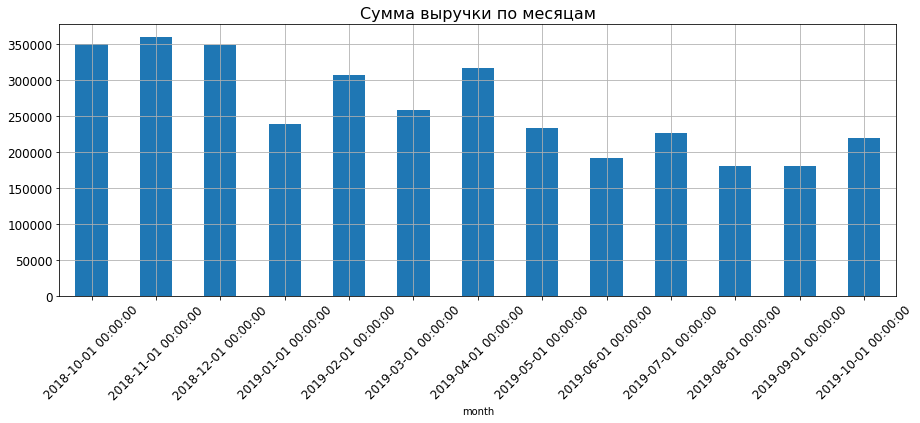

In [36]:
clear_df.pivot_table(index='month', values='revenue', aggfunc='sum')\
.plot(kind='bar', figsize=(15,5), grid=True, y=['revenue'], fontsize=12, legend=False)
plt.title('Сумма выручки по месяцам', fontsize=16)
plt.xticks(rotation=45)
plt.show()

Максимальная выручка интернет-магазина была в ноябре 2018 года, после марта 2019 года выручка постепенно снижается

Рассчитаем топ-10 товаров, которые принесли максимум выручки за рассматриваемый период

In [37]:
top_revenue = clear_df.pivot_table(index=['product','price'], values='revenue', aggfunc='sum').head(10)\
.sort_values(by='revenue', ascending=False)
top_revenue

revenue
product                                                                                  price              
Ёрш унитазный с деревянной ручкой , Ваир 1712012                                         56.000    3,808.000
Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759                                        2,399.000 2,399.000
Tepмокружка AVEX Freeflow 700 мл сталь AVEX0776                                          2,399.000 2,399.000
Tepмокружка AVEX Recharge 500 мл голубой AVEX0681                                        2,324.000 2,324.000
                                                                                         1,874.000 1,874.000
Ёрш унитазный с деревянной ручкой , Ваир 1712012                                         51.000    1,530.000
Ёрш для бутылки из натурального волокна и металла 23 см кремовый, Burstenmann, 0473/0003 142.000   1,420.000
Ёрш бутылочный с металлической ручкой малый Y64 1807002                                  22.000      220.000
Ёрш радиаторный без ручки 1807007                                                        60.000      120.000
Ёрш унитазный пластмассовый, Ваир 1712002                                                44.000       44.000

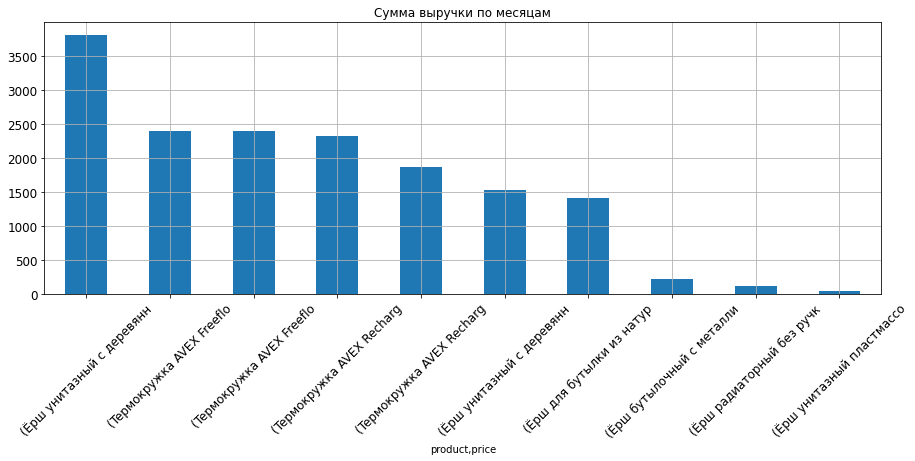

In [38]:
top_revenue.plot(kind='bar', figsize=(15,5), grid=True, y=['revenue'], fontsize=12, legend=False)
ax=plt.gca()
ax.set_xticklabels(item.get_text()[:25] for item in ax.get_xticklabels())
plt.title('Сумма выручки по месяцам')
plt.xticks(fontsize = 12, rotation=45)
plt.show()

Максимальную выручку за весь период принесли продажи ершей унитазных с деревянной ручкой, при цене 56 ден. ед. за весь период они принесли 3808 ден. ед. выручки, на втором, третьем и четвертом местах - термокружки, замыкает пятерки лидеров снова ерш унитазный, но с ценой 51 ден. ед.

Посмотрим какие товары принесли меньше всего совокупной выручки за период

In [39]:
bottom_revenue = clear_df.pivot_table(index=['product','price'], values='revenue', aggfunc='sum').tail(10)\
.sort_values(by='revenue')
bottom_revenue

,,revenue
product,price,
томата (помидор) Фейерверк № 114 сорт индетерминантный среднеспелый красный,38.000,38.000
томата (помидор) Шалун № 118 сорт индетерминантный раннеспелый розовый,38.000,38.000
томата (помидор) Шахерезада №84 сорт детерминантный среднеспелый красный,38.000,38.000
томата (помидор) Ширли сердцевидный № 119 сорт индетерминантный среднеспелый розовый,38.000,38.000
томата (помидор) Южный вечер № 120 сорт детерминантный среднеспелый черный,38.000,38.000
томата (помидор) Черниченский черри № 116 сорт индетерминантный позднеспелый черный,38.000,114.000
томата (помидор) Шаймет криг №117 сорт детерминантный раннеспелый красный,38.000,190.000
томата (помидор) Юсуповский Узбекский №86 сорт индетерминантный позднеспелый красный,38.000,532.000
томата (помидор) Этуаль №85 сорт детерминантный среднеспелый розовый,38.000,608.000


Очень плохо продается рассада томатов различных сортов, возможно стоит рассмотреть вариант снятия данных товаров с продажи. Далее проверим выручку по товарным группам и примем окончательное решение

### 3.3 Расчет количества уникальных покупателей в месяц


Метрика MAU

In [40]:
mau = clear_df.groupby(['month']).agg({'customer_id': 'nunique'}).mean()
print('Количество уникальных покупателей в месяц составляет {} человек'.format(int(mau)))

Количество уникальных покупателей в месяц составляет 192 человек


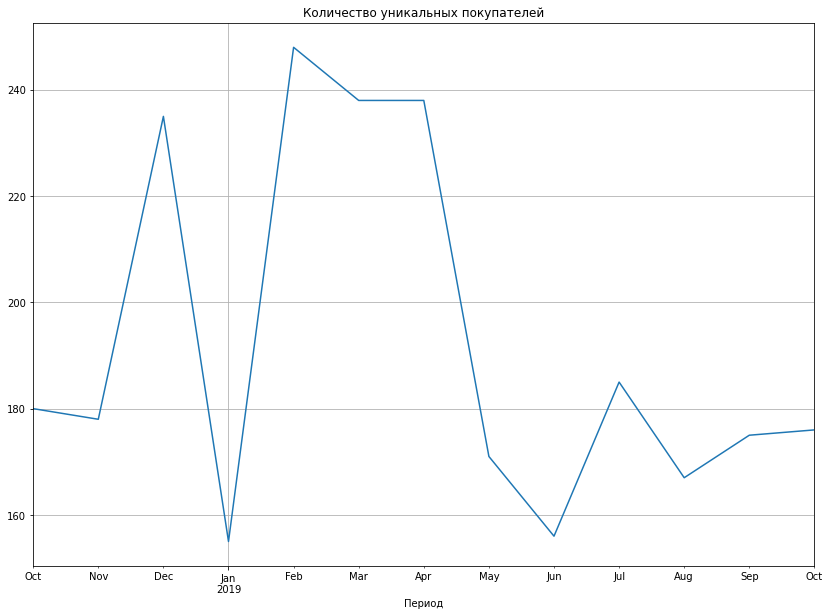

In [41]:
clear_df.groupby(['month']).agg({'customer_id': 'nunique'}) \
.plot(kind='line', legend=False, grid=True)
plt.title('Количество уникальных покупателей')
plt.xlabel('Период')
plt.show()

Судя по графику можно заметить сезонность, количество покупателей увеличивается ближе к празникам (новый год и 8 марта)

### 3.4 Расчет количества уникальных заказов

In [42]:
order_mean = clear_df.groupby(['month']).agg({'order_id': 'nunique'}).mean()
print('Количество уникальных заказов в месяц составляет {} штук'.format(int(order_mean)))

Количество уникальных заказов в месяц составляет 215 штук


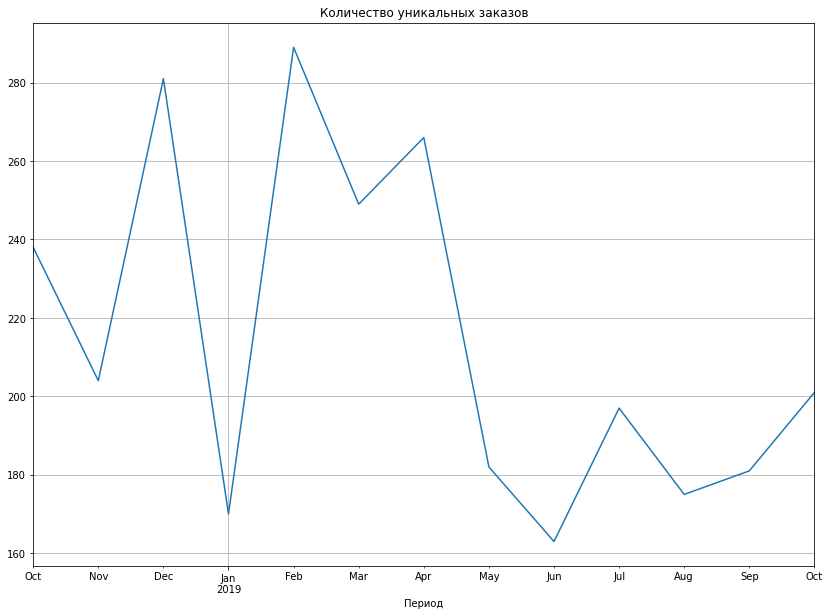

In [43]:
clear_df.groupby(['month']).agg({'order_id': 'nunique'}) \
.plot(kind='line', legend=False, grid=True)
plt.title('Количество уникальных заказов')
plt.xlabel('Период')
plt.show()

Аналогично изменению количества уникальных пользователей в графике присутствует сезонность, количество заказов растет перед новым годом и в феврале, марте. В январе и летом количество заказов критично снижается

### 3.5 Выводы по пункту 3

Максимальную выручку за весь период принесли продажи ершей унитазных с деревянной ручкой, при цене 56 ден. ед. за весь период они принесли 3808 ден. ед. выручки, на втором, третьем и четвертом местах - термокружки, замыкает пятерки лидеров снова ерш унитазный, но с ценой 51 ден. ед. Очень плохо продается рассада томатов различных сортов

## 4 Анализ товарного ассортимента

### 4.1 Формирование основных товарных групп

Наименования товаров содержат числовую, буквенную информацию, большие и маленькие буквы, знаки препинания, английские и русские буквы алфавита.
<br>Для того, что выделить товарные категории, необходимо привести информацию к более простому виду

Для начала приведем все наименования в строчный регистр

In [44]:
clear_df['product'] = clear_df['product'].str.lower()
clear_df.head()

,date,customer_id,order_id,product,quantity,price,month,revenue
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.000,2018-10-01,142.000
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.000,2018-10-01,194.000
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.000,2018-10-01,112.000
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.000,2018-10-01,179.000
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.000,2018-10-01,112.000


Необходимо еще упростить названия, уберем буквы латинского алфавита, цифры и знаки препинания и слова, состоящие из 1 или 2 символов

In [45]:
clear_df['product'] = clear_df['product'].str.replace(r'[^а-яА-ЯёЁ]', ' ', regex = True)
clear_df['product'] = clear_df['product'].str.replace(r'\b\w{1,2}\b', ' ', regex = True)

Применим лемматизацию для выделения основных нормальных форм слова

In [46]:
clear_df['product'].unique()
text = ''
for row in df['product']:
    text += row + ' '
m = Mystem() 
lemmas = m.lemmatize(text)
print(Counter(lemmas)) 

Counter({' ': 49592, 'см': 2548, '-': 2502, ', ': 2423, 'рассада': 1599, 'кассета': 1209, 'для': 1187, 'сорт': 1056, 'шт': 964, 'пеларгония': 921, 'по': 903, ',': 795, 'в': 741, '6': 730, 'л': 715, '5': 606, '. ': 587, 'диам': 555, '0': 553, 'd': 551, 'зональный': 540, '12': 532, 'объем': 491, 'белый': 482, 'махровый': 476, 'кабачок': 467, 'тележка': 456, '6шт': 450, 'с': 449, 'красный': 436, 'сумка': 424, ' (': 414, '9': 394, 'черенок': 381, 'укоренять': 379, '2': 364, 'E6': 362, 'цветок': 353, 'белье': 351, ') ': 348, '10': 331, 'горшок': 321, 'сушилка': 317, 'кухня': 300, 'зелень': 295, 'Gimi': 294, 'однолетний': 294, 'розебудный': 283, 'доска': 275, 'огурец': 267, '7': 251, 'синий': 242, '/': 240, 'розовый': 236, '4': 228, 'гладильный': 226, 'х': 214, 'полумахровый': 210, 'муляж': 207, 'петуния': 203, 'h': 198, 'томат': 190, 'колесный': 188, 'ника': 188, 'россия': 185, '1': 182, 'помидор': 182, 'м': 180, '30': 180, '№': 180, '20': 177, 'сиреневый': 174, 'кг': 167, 'и': 160, 'хозяйс

In [47]:
clear_df.head()

,date,customer_id,order_id,product,quantity,price,month,revenue
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение горшке алое вера,1,142.000,2018-10-01,142.000
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение горшке кофе арабика,1,194.000,2018-10-01,194.000
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера,1,112.000,2018-10-01,112.000
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс,1,179.000,2018-10-01,179.000
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула,1,112.000,2018-10-01,112.000


В данном цикле я просматриваю те леммы, которые выглядят неоднозначно и их надо проверить

In [48]:
list_product = [

 ]
for word in list_product:
    fg = clear_df[clear_df['product'].str.contains(word, regex=False, case=False, na=False)]
    print(fg['product'].head(1))

In [49]:
lemmas = []
for lem in df['product'].unique():  
    lemma = m.lemmatize(lem)
    lemmas.append(lemma)
    
#создадим словари
plant = ['растение', 'рассада', 'сорт', 'пеларгония', 'кабачок', 'пахира',\
         'черенок', 'цветок', 'зональная', 'диам', 'кассета', \
         'горшок', 'зелень','огурец', 'петуния', 'томат', \
         'помидор', 'патиссон', 'ячейка', 'герань', 'калибрахоа', 'роза', 'тагетис', 'золотинка',\
         'тимьян', 'арбуз','капуста', 'белогор', 'мята', 'розмарин', 'базилик', 'вербена', 'дыня', \
         'фуксия', 'смесь', 'лобелия', 'кашпо',  'лаванда','тыква', 'эвкалипт','клубника','душица',\
         'чабрец','трава','примула','мелисса','декабрист', 'лавр', 'букет', 'цикламен','петрушка', \
         'фиалка','ромашка','регатт','арабик','бегония','флокс','мультиблум','скарлет','кольраби',\
         'гунни','орегано','циперус','зумул','перец','баклажан','кофе',\
         'морокан','ауреум','калла','табак','сильвердроп','антуриум',\
         'кориандр','розебуд','крокус','пуансеттия','овощ','тюльпан','колокольчик','чили','алиссум',\
         'плющ','шалфей','эклипсы','сельдерей','андрианум', 'василиса' ,'ландыш' ,'горошек' ,'овсянница',\
         'портулак','хлорофитум', 'хризантема' ,'спирелла','луковица','сетка','сальвия' ,'эхевери', \
         'маргарита', 'остеоспермум','азалия', 'циния', 'лилия', 'мимоза', 'спатифиллум', 'оффициналис',\
         'астра','гербера','шпинат', 'гортензия', 'открыт','земляника', 'розебад', 'акаулис','дендробиум',\
         'цинния','нарцисс','калатея', 'аспарагус','чеснок', 'корица', 'чабер', 'зверобой','магнифика', \
         'стоунмания', 'настурция', 'гардения', 'календула', 'кореопсис', 'каланхое','алоэ', 'папоротник', 'целозия',\
         'подарочный', 'новогод','черри', 'цинерания', 'бейби', 'самурай', 'бургунди',\
         'кения','сциндапсус', 'колибри', 'эхинокактус','голдни', 'гиацинт','незабудка', 'укроп', 'георгин', \
         'фазенда', 'цитриодорус', 'эхинацея','цинерария', 'лаура', 'василек', 'аргирантерум', 'брокколи', \
         'абрикос','джессика','аделин','барао','хурма','цитрофортунелла','кумкват','пеперомия','орхидея',\
         'лемонграсс','пион','грейпфрут','гелихризум','муррайя','глория','мангольд','маттиола','лук',\
         'порей','драцена','фрагранс','рукол','хризолидокарпус','лутесценс','юкка', \
         'суккулент', 'артемизия', 'адиантум','капсикум','бархатцы','годеция','рембранд','друммонд','эшшольция',\
         'трибатрон','пуансетия','фиорино','гимнокалициум','амброзия','нефролепис', \
         'родос','мистигря','томрис','лейс', 'фиттоний','рубелла','фикус','балезино','офелия','одри',\
         'пихта','розетт', 'шеффлер','радермахер','алое','мединил','мирт','микс','комнатный','многолетний',\
         'эхеверие','мединилла','литопс','кампануть','нолина','глоксиния','цветущий','иссоп',\
         'сантолина','афеляндра','молодить','салат','бальзамин','диффенбахий','фаленопсис','амариллис',\
         'колеус', 'молодило','альбук','крассула','замиокулькас','калоцефалус','соланум','каллун','косметь',
         'импатиенс','клен','однолетний','львиный','лапчатка','подсолнечник','вигна','хамедорей','лантан',\
         'гиностемма','аптение','кипарисовик','любисток','змееголовник','валериана','буддлей',\
         'ель','новогодний','анемон','аквилегия','монард','скиммия','лаватер','нивянник','камнеломка',\
         'подвесное','подвесной','бакоп','кодонант','барвинок','вербейник','фатсия','гипсофил','котовник',\
         'вероника','ясколка','бадан','эпипремнум','седум','ранункулус','газание','смолевка','виола',\
         'лилейник','платикодон','энотера','синнингия','девичий','бузульник','физостегия','солидаго','пряный',\
         'мускарь','пиретрум','агератум','агератум','левка','джункус','хоста','рудбекия','гайлардий','осина'
        ]
stuff = ['тележка', 'сумка', 'белье','сушилка','коврик', 'доска', \
         'гладильный','колесный', 'чайник', 'чехол', 'лоток', 'лестница', 'коврик', 'вешалка', 'ёрш', 'урна',\
         'лиана', 'штора', 'таз', 'щетка','каркас', 'диск', 'вешалка', 'стремянка', 'ступень', 'окно', 'полка', \
         'карниз', 'одежда','термометр','упаковка','липучка', 'швабра', 'контейнер', 'крючок', 'салфетка', 'ерш',\
         'насадка','ведро','подкладка','лестница','обув','перчатк','корыто','батаре','ковер','костюм',\
         'коробка','лоток','кофр','урна','ящик', 'замок','весы','пузыр', 'блуз', 'этажерка','подарок', \
         'совок', 'овощеварка', 'мешок', 'веник','пепельница', 'утюг', 'дозатор', 'унитаз','медикамент','комод', \
         'вантуз','пробка', 'ковш','табурет','капучино', 'батарейка','стеллаж','мясорубка','электроштопор',\
         'мантоварка','зажигалка', 'кисточка','краник', 'пылесос', 'ножеточка','соковарка','овощечистка',
         'ножницы','орехокол','картофелемялка','напильник','обувница','кипятильник','орехоколка',\
         'пароварка', 'фен','тряпка','бидон','шприц', 'бутыл','светодиодный', 'мыльница','лезвие', 'губка', \
         'ключница', 'картина','настенный','котел','мусорный','перчатка','основание','светильник','сидение',\
         'подголовник','короб','вакуумный','настольный','сервировочный','запасный','штанга','пьезозажигалка',\
         'сметка','линейка','измерительный','полк','соковыжималка','бензин','держатель','измельчитель','ролик',\
         'сменный','отделитель','прищепок','шило','бельевой','окномойка','рассекатель','защитный','многофункциональный',\
         'фоторамка','ванна','складной','антинакипин','бак','автоматический','отжим','тряпкодержатель'
        ]
dishes = ['салатник', 'крышка', 'тарелка',  'салатник', 'нож',\
          'сковорода','ложка','чайник', 'банка','подставка','посуда' ,'салфетка',\
          'стакан','термокруж', 'кастрюля' ,'кружка','вилка' ,'кувшин','блюдо', 'фужер', 'терка','термос',\
          'миксер', 'горох', 'емкость', 'бокал', 'миска', 'блюдце', 'хлебница', \
          'скалка', 'толкушка', 'рыбочистка','ягода','хлеб','лайм','термостакан', 'стол',\
          'сотейник','корзинка','ваза','венчик','сито','бульонница', 'масленка','салфетница',\
          'дуршлаг','сахарница','набор','мерный','противень','стеклянный','просеиватель',\
          'вкладыш','мини','половник','термокружок','мокружкa','чайный','столовый','лопатка','жестяной',\
          'кухонный','скребок','разделочный','пресс','фарфоровый','модульный','форма','тортница'
         ]
tool = ['кассета', 'крепеж', 'нож', 'ручка', 'кольцо', 'корзина', 'скатерть', 'плечики','пружина','болт',\
         'крепеж','крепление', 'шарнир', 'метиз', 'инструмент', 'веревка', 'утюжок', 'труб',\
         'уголок', 'фиксатор', 'рукоятка', 'шпингалет','скоба','стяжка','петля','холодный','сверло',\
         'решетка','универсальный','шнур','завертка','шпагат','штангенциркуль'
       ]
dummy = ['муляж', 'искусственный', 'гвоздик', 'персик', 'груша','виноград','лимон','морковь','банан',\
        'гранат','мандарин', 'магнит','вишня', 'подснежник','апельсин', 'вино','ананас','черешня',\
        'декоративный'
        ]
household = ['порошок','мыло','паста', 'облепиха', 'стирк', 'кондиционер', 'отбеливатель','ополаскиватель',\
             'биопорошок','крем', 'профилакт','заболев', 'сувенир','стиральный','чистить','пена','жидкий',\
             'зубной','средство','антижир','ароматизированный','бальзам','гипоаллергенный','увлажнять',\
             'концентрат'
            ]
textile = ['полотенце','плед', 'простыня', 'покрывало', 'наволочка', 'наматрасник','одеяло', 'подушка',\
           'халат','постельный', 'пододеяльник', 'двуспальный','махровый','плед','готовый','ткань',\
           'комплект','подрукавник','рукав','покрытие','наматрицник','лен','нетканый','фал','наматрацник'
          ]

def cat_product(category):
    row = m.lemmatize(category)
    for word in row:
        if word in plant:
            return 'растения'
        if word in stuff:
            return 'материалы'
        if word in dishes:
            return 'посуда'
        if word in dummy:
            return 'муляжи'            
        if word in tool:
            return 'инструменты'
        if word in household:
            return 'хозяйственные средства'
        if word in textile:
            return 'текстиль'
        else:
            return 'посуда' #так как остались только 4 строки с товаром tермокружка, изначально названным неверно
                            #лемма к нему не формируется
clear_df['product_category']= clear_df['product'].apply(cat_product)        
clear_df.head()

,date,customer_id,order_id,product,quantity,price,month,revenue,product_category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение горшке алое вера,1,142.000,2018-10-01,142.000,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение горшке кофе арабика,1,194.000,2018-10-01,194.000,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера,1,112.000,2018-10-01,112.000,растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс,1,179.000,2018-10-01,179.000,растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула,1,112.000,2018-10-01,112.000,растения


Проверяем отсутствие товаров без категории

In [50]:
print(clear_df.loc[clear_df['product_category']  == ''])

Empty DataFrame
Columns: [date, customer_id, order_id, product, quantity, price, month, revenue, product_category]
Index: []


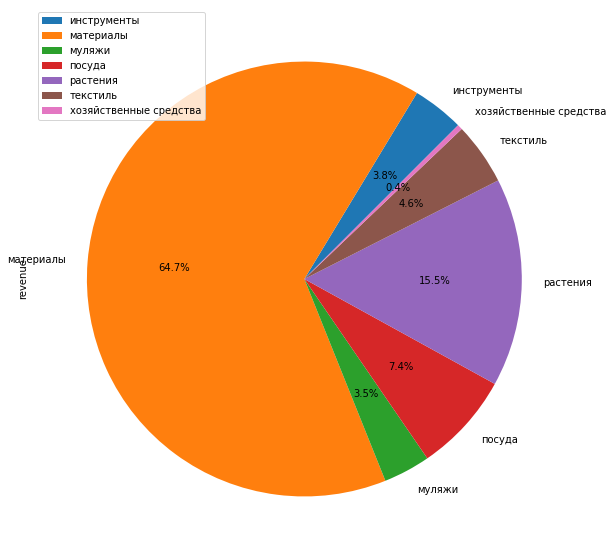

In [51]:
clear_df.groupby(['product_category']).sum().plot(
    kind='pie', y='revenue',startangle=45,figsize=(20,10), autopct='%1.1f%%'
);

Самой популярной категорией является категория Материалы, затем идет категория Растения. Остальные категории в общей массе занимают общую долю, не превышающую 10%

### 4.2 Разделение товаров по сезонам

Выделим номер месяца

In [52]:
clear_df['number_month'] = clear_df['month'].dt.month
clear_df.sample(5)

,date,customer_id,order_id,product,quantity,price,month,revenue,product_category,number_month
1838,2019-02-15 14:00:00,11f83991-ae0e-40bb-83ff-497f24103e75,70278,примула желтая оранжевым горшке,1,127.000,2019-02-01,127.000,растения,2
2699,2019-04-06 14:00:00,3deae7f7-bb20-43a3-b83c-ed9ba5ab48dc,71038,мята перечная тач мандариновая мята укорененный черенок,1,74.000,2019-04-01,74.000,растения,4
1075,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,космея клюквенный клик,1,22.000,2018-12-01,22.000,растения,12
1947,2019-02-22 03:00:00,09a5e5d4-be3f-4c62-a2c6-8bb3f2c39df5,70398,фал капроновый бухте,1,"2,099.000",2019-02-01,"2,099.000",текстиль,2
1311,2018-12-23 04:00:00,2878c1b9-220e-4604-8f60-f09bbca1a688,69517,вешалка закругленными плечиками перекладиной крючками противоскользящим покрытием ...,15,81.000,2018-12-01,"1,215.000",материалы,12


Присвоим каждой строке датасета категорию (зима, лето, осень, весна) опираясь на месяц покупки

In [53]:
def season_p(num):
    for month in range(1,12,1):
        if num in (1,2,12):
            return 'зима'
        if num in (3,4,5):
            return 'весна'
        if num in (6,7,8):
            return 'лето'        
        else:
            return 'осень'
clear_df['product_season']= clear_df['number_month'].apply(season_p)        
clear_df.sample(5)

,date,customer_id,order_id,product,quantity,price,month,revenue,product_category,number_month,product_season
3852,2019-05-16 22:00:00,ca274b0b-9724-4be9-b834-3f6749fc683f,14784,рассада зелени для кухни базилик шалун кассета,1,169.000,2019-05-01,169.000,растения,5,весна
968,2018-11-24 23:00:00,2dab8d4b-62e4-4cdd-b812-6dd3b298f89a,69111,швабра сальса треугольная мини,1,524.000,2018-11-01,524.000,материалы,11,осень
2992,2019-04-21 11:00:00,5f6d318b-4ed0-4163-8767-2959bc2e6c76,14664,рассада зелени для кухни ориганум ауреум голд диам,1,120.000,2019-04-01,120.000,растения,4,весна
3693,2019-05-13 17:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14763,однолетнее растение петуния махровая кассете россия,2,82.000,2019-05-01,164.000,растения,5,весна
1633,2019-01-30 12:00:00,b5314f48-d92a-43d3-a021-2c4274ff2130,70027,штора для ванной комнаты бежевая текстильная,1,"1,162.000",2019-01-01,"1,162.000",материалы,1,зима


In [54]:
top_revenue_season = clear_df.pivot_table(index=['product_season'], values='revenue', aggfunc='sum')\
.sort_values(['revenue'], ascending=False)
top_revenue_season.columns = ['Суммарная выручка']
top_revenue_season

,Суммарная выручка
product_season,
осень,"1,111,090.000"
зима,"895,975.000"
весна,"810,659.000"
лето,"599,998.000"


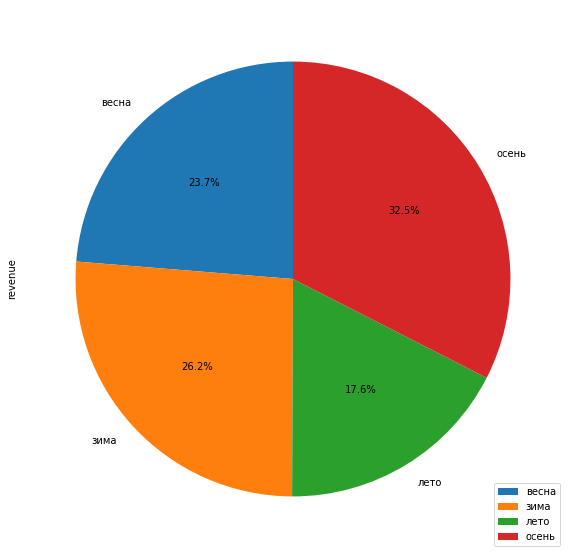

In [55]:
clear_df.groupby(['product_season']).sum().plot(kind='pie', y='revenue',startangle=90,figsize=(15,10), autopct='%1.1f%%');

Наибольшая выручка достигается в осенний сезон, а наименьшая в летний

### 4.3 Определение общей выручки по товарным группам и сезонности

In [56]:
top_revenue_group = clear_df.pivot_table(index=['product_category','product_season'], values='revenue', aggfunc='sum')\
.sort_values(['product_category', 'revenue'], ascending=[True,False])
top_revenue_group.columns = ['Суммарная выручка']
top_revenue_group

Суммарная выручка
product_category       product_season                   
инструменты            осень                  59,931.000
                       лето                   29,683.000
                       зима                   28,839.000
                       весна                  12,622.000
материалы              осень                 764,600.000
                       зима                  592,953.000
                       весна                 432,139.000
                       лето                  423,092.000
муляжи                 осень                  51,900.000
                       весна                  33,618.000
                       зима                   25,753.000
                       лето                    7,882.000
посуда                 осень                 112,989.000
                       зима                   75,267.000
                       весна                  39,874.000
                       лето                   25,486.000
растения               весна                 254,065.000
                       лето                   98,990.000
                       осень                  89,985.000
                       зима                   86,777.000
текстиль               зима                   82,838.000
                       весна                  36,413.000
                       осень                  29,918.000
                       лето                    9,101.000
хозяйственные средства лето                    5,764.000
                       зима                    3,548.000
                       весна                   1,928.000
                       осень                   1,767.000

Получим, что по всем категориям, кроме категорий растения и хозяйственные средства, летом происходит спад в выручке.
<br>Пик продаж в категории растения приходится на весну, а у хозяйственных средств на лето

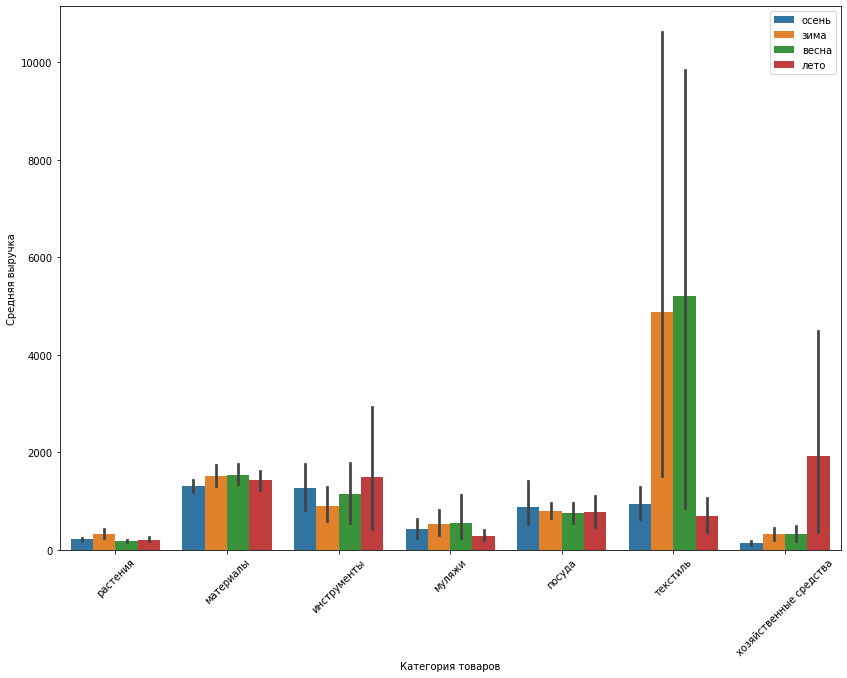

In [57]:
sns.barplot(x='product_category', y='revenue', hue ='product_season', data=clear_df)
plt.legend()
plt.xticks(rotation=45)
plt.ylabel('Средняя выручка')
plt.xlabel('Категория товаров')
plt.show();

### 4.5 АВС анализ ассортимента

А – это основная группа товаров, приносящая около 80% прибыли.
<br>В – эти товары приносят около 15% прибыли.
<br>С – приносят оставшиеся 5% прибыли

In [58]:
abc_df = clear_df.sort_values('revenue', ascending=False)
abc_df['part'] = abc_df['revenue']/abc_df['revenue'].sum()
abc_df['cum_part']=abc_df['part'].cumsum()
abc_df['abc_group'] = "C"
abc_df['abc_group'][abc_df.cum_part <= 0.8] = "A"
abc_df['abc_group'][(abc_df.cum_part <= 0.95) & (abc_df.abc_group != "A")] = "B"
abc_df[['product_season','product_category','product','revenue','abc_group']]

,product_season,product_category,product,revenue,abc_group
1518,зима,текстиль,простынь вафельная хлопок,"47,385.000",A
1299,зима,материалы,тележка багажная тбр синий грузоподъемность сумка каркас россия,"32,718.000",A
1023,осень,посуда,набор ножей предметов,"29,248.000",A
661,осень,материалы,урна уличная гео хоббика сталь,"24,370.000",A
1675,зима,материалы,мусорный контейнер хром,"16,536.000",A
...,...,...,...,...,...
6388,осень,растения,томат балконное чудо,10.000,C
6389,осень,растения,укроп обильнолистный,10.000,C
5642,лето,растения,алиссум лобулярия снежные одежды,9.000,C
2159,весна,посуда,горох амброзия,9.000,C


In [59]:
abc_df_group = abc_df.pivot_table(index=['abc_group','product'], values='revenue', aggfunc='sum')\
.sort_values(['abc_group', 'revenue'], ascending=[True,False])
abc_df_group.columns = ['Суммарная выручка']
abc_df_group

Суммарная выручка
abc_group product                                                                                                
A         простынь вафельная                                  хлопок                                   53,232.000
          сумка тележка     колесная           синяя                                                   50,405.000
          тележка багажная       тбр    синий грузоподъемность      сумка        каркас россия         44,443.000
          сумка тележка хозяйственная                                    синяя                         35,244.000
          муляж яблоко     красное                                                                     32,230.000
...                                                                                                           ...
C         петрушка итальянский гигант                                                                      10.000
          цинния коралловая красавица                                                                      10.000
          цинния оранжевый король                                                                          10.000
          горох амброзия                                                                                    9.000
          львиный зев волшебный ковер                                                                       9.000

[2470 rows x 1 columns]

In [60]:
a_df_group = abc_df.loc[(abc_df['abc_group']  == 'A')].sort_values(['revenue'], ascending=False)
a_df_group[['product_season','product_category','product','revenue','abc_group']].head(10)

,product_season,product_category,product,revenue,abc_group
1518,зима,текстиль,простынь вафельная хлопок,"47,385.000",A
1299,зима,материалы,тележка багажная тбр синий грузоподъемность сумка каркас россия,"32,718.000",A
1023,осень,посуда,набор ножей предметов,"29,248.000",A
661,осень,материалы,урна уличная гео хоббика сталь,"24,370.000",A
1675,зима,материалы,мусорный контейнер хром,"16,536.000",A
2971,весна,текстиль,одеяло белое темостеганое чехол полиэстер,"15,680.000",A
3961,весна,муляжи,муляж яблоко красное,"15,300.000",A
5992,лето,материалы,сушилка уличная зеленая,"14,917.000",A
2970,весна,текстиль,наматрацник бархатный бамбук односпальный хлопок стеганый рез...,"14,196.000",A
2969,весна,материалы,салфетка аметист белая,"11,460.000",A


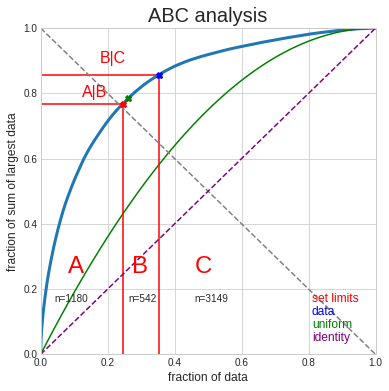

In [61]:
dctAnalysis = abc_analysis(clear_df['revenue'], True)

Из графика мы видим, что в группу А попало 1180 строк (покупок), в группу В - 542 и в группу С - 3149.
<br>Штрихпунктирная линия означает идеальной, но недостижимый вариант распределения товаров по группам А, В и С (в ситуации когда 80% товаров приносят 80% прибыли и т.д.)
<br>Зеленая линия показывает унифицированный вариант
<br>И наконец синия кривая - это вариант, который получился на реальных данных
<br>Для данного набора данных происходит вычисление точных пределов для получения подмножеств. Кривая ABC визуализирует данные, графически представляя кумулятивную функцию распределения. Данные делятся на три непересекающихся подмножества A, B и C, причем подмножество A содержит очень выгодные варианты, подмножество B содержит значения, где доходность равна усилиям, необходимым для ее получения, и подмножество C, содержащее неприбыльные варианты 
<br>Таким образом данный график дает нам понять, чтополученное распределение товаров по группам А, В и С не идеально.
<br>Вывод же мы делаем по таблице, в которой я сгруппировала товары по наименованиям продукта, выделила 10 товаров, относящихся к группе А, и приносящих максимальную выручку. Если заказчик захочет увидить большее количество товаров (к примеру все товары группы А), то можно вывести их все и расписать в выводе все товары на которые следует обратить повышенное внимание.

При проведении АВС-анализа мы получили товары на которые следует обратить максимальное внимание, это категория А, которая приносит 80% прибыли.
<br>
В частности это такие товары как:
- простынь вафельная хлопок,
- тележка багажная тбр синий,
- набор ножей,
- урна уличная гео хоббика сталь,
- мусорный контейнер хром

### 4.6 Кластеризация пользователей

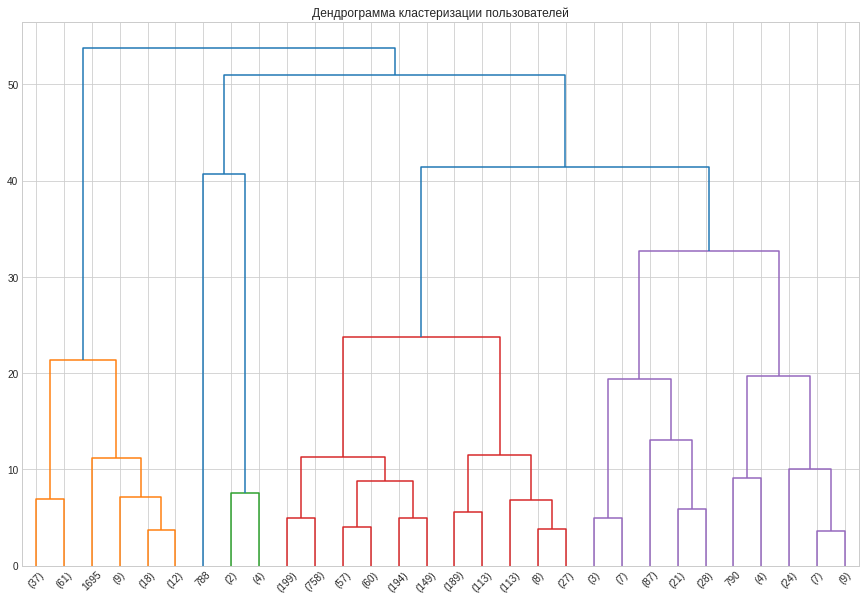

In [62]:
clusters = clear_df.pivot_table(index = 'product', aggfunc = {'order_id': 'nunique', 'quantity': 'sum', 'price': 'mean'})
clusters.columns = ['orders', 'quantity', 'price']
# Стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(clusters)
# Построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')
# Построим дендрограмму
plt.figure(figsize=(15, 10)) 
dendrogram(linked, orientation='top', show_leaf_counts=True, truncate_mode='lastp', leaf_rotation=45)
plt.title('Дендрограмма кластеризации пользователей')
plt.show()

Исходя из дендограммы можно предположить деление покупателей на два основных кластера

#### 4.6.1 Обучение модели кластеризации на основании алгоритма K-Means

In [63]:
km = KMeans(n_clusters=2, random_state=0)
labels = km.fit_predict(X_sc)
clusters['cluster_km'] = labels
clusters.cluster_km.value_counts()

0    2142
1      61
Name: cluster_km, dtype: int64

In [64]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.81


Значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация.
Следовательно, наша кластеризация проведена на достаточно высоком уровне

#### 4.6.2 Расчет информации для каждого кластера

In [65]:
clusters.groupby('cluster_km').mean().T

cluster_km,0,1
orders,1.792,15.787
quantity,624.809,174.975
price,3.801,71.328


#### 4.6.3 Графики, которые характеризуют кластеризацию

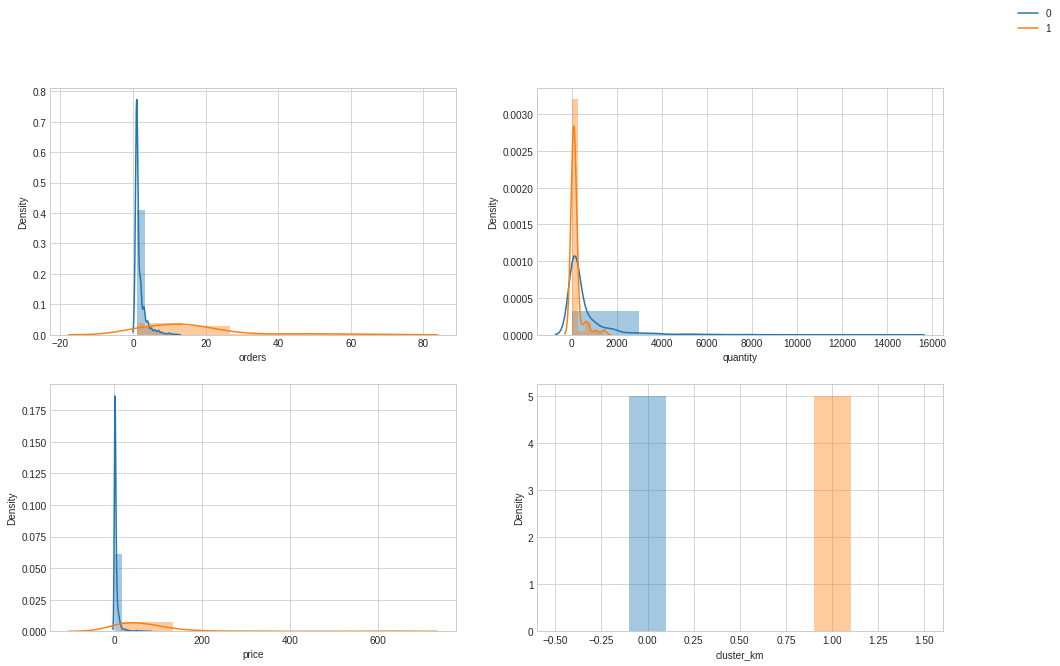

In [66]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))
ax = ax.ravel()
for n, feature in enumerate(clusters.columns):
    for i in (0, 1):
        sns.distplot(clusters[clusters['cluster_km'] == i][feature], bins=5, ax=ax[n], kde = True)
fig.legend(labels=['0','1'])
plt.show();

#### 4.6.4 Выводы по пункту 4.6

Присутствует координальное различие в профилях покупателей.
- Характеристики кластера 0: среднее количество заказов за период 1,8; среднее количество купленного товара в одном заказе - 624 ед.; средняя цена товара 3,8 ден. ед.
- Характеристики кластера 1: среднее количество заказов за период 15,8; среднее количество купленного товара в одном заказе - 175 ед.; средняя цена товара 71,3 ден. ед.
- Предположим, что кластер 0 характеризует собой мелкооптовых покупателей, которые покупают достаточно редко, но при этом оформляют заказ на большое количество позиций с невысокой средней ценой.
- Кластер 1 характеризует обычных розничных покупателей, которые совершают покупки достаточно часто, но при этом на малое количество товаров, при этом средняя цена товара намного выше, чем у оптовиков

### 4.7 Выводы по пункту 4

- В данном пункте была произведена классификация всех товаров по восьми товарным группам: растения, материалы, посуда, муляжи, инструменты, хозяйственные средства, текстиль и посуда. Самой популярной категорией является категория Материалы, затем идет категория Растения. Остальные категории в общей массе занимают общую долю, не превышающую 10%.
- Также была произведена классификация заказов по сезону. Наибольшая выручка достигается в осенний сезон, а наименьшая в летний.
- По всем категориям, кроме категорий растения и хозяйственные средства, летом происходит спад в выручке. Пик продаж в категории растения приходится на весну, а у хозяйственных средств на лето
- При проведении АВС-анализа мы получили товары на которые следует обратить максимальное внимание, это категория А, которая приносит 80% прибыл (простынь вафельная хлопок, тележка багажная тбр синий, набор ножей, урна уличная гео хоббика сталь, мусорный контейнер хром)
- Произведена кластеризация пользователей, было принято решение разделить всех пользователей на два кластера (розничные и оптовые покупатели).

## 5 Проверка гипотез

### 5.1 О равенстве среднего количества товара в заказе у розничных и мелкоптовых покупателей

Сформулируем нулевую и альтернативную гипотезы:
<br>Н0: нет статистически значимых различий в среднем количестве товара в заказе у розничных и мелкоптовых покупателей
<br>Н1: есть статистически значимые различия в среднем количестве товара в заказе у розничных и мелкоптовых покупателей
<br>Пороговое значение alpha примем равным 0,05

In [67]:
alpha = .05

results = stat.ttest_ind(
    clusters.loc[clusters.loc[:,'cluster_km'] == 0]['quantity'],
    clusters.loc[clusters.loc[:,'cluster_km'] == 1]['quantity']
)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.0017282413594331863
Отвергаем нулевую гипотезу


In [68]:
quantity_cluster_0 = clusters[clusters['cluster_km']==0]['quantity']
quantity_cluster_1 = clusters[clusters['cluster_km']==1]['quantity']
print('Среднее значение количества товара у нулевого кластера: {} ед.'.format(int(np.mean(quantity_cluster_0))))
print('Среднее значение количества товара у первого кластера: {} ед.'.format(int(np.mean(quantity_cluster_1))))

Среднее значение количества товара у нулевого кластера: 624 ед.
Среднее значение количества товара у первого кластера: 174 ед.


Отвергаем нулевую гипотезу, следовательно, среднее количество товара в заказе у мелкоптовых и розничных покупателей имеет статистически значимые отличия

### 5.2 О равенстве средней выручки в весенне-летний и зимне-осенний сезоны

Сформулируем нулевую и альтернативную гипотезы:
<br>Н0: нет статистически значимых различий в величине средней выручки в весенне-летний и зимне-осенний сезоны
<br>Н1: есть статистически значимые различия в величине средней выручки в весенне-летний и зимне-осенний сезоны
<br>Пороговое значение alpha примем равным 0,05

In [69]:
alpha = .05

results = stat.ttest_ind(
    clear_df.loc[(clear_df.loc[:,'product_season'] == 'весна') | (clear_df.loc[:,'product_season'] == 'лето')]['revenue'],
    clear_df.loc[(clear_df.loc[:,'product_season'] == 'осень') | (clear_df.loc[:,'product_season'] == 'зима')]['revenue'],
)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 3.5964754183535715e-17
Отвергаем нулевую гипотезу


In [70]:
revenue_sp_summer = clear_df[(clear_df['product_season']=='весна') | (clear_df['product_season']=='лето')]['revenue']
revenue_ot_winter = clear_df[(clear_df['product_season']=='осень') | (clear_df['product_season']=='зима')]['revenue']
print('Среднее значение выручки в весенне-летний период: {} ден.ед.'.format(int(np.mean(revenue_sp_summer))))
print('Среднее значение выручки в зимле-осенний период: {} ден.ед.'.format(int(np.mean(revenue_ot_winter))))

Среднее значение выручки в весенне-летний период: 531 ден.ед.
Среднее значение выручки в зимле-осенний период: 905 ден.ед.


Отвергаем нулевую гипотезу, следовательно, есть статистически значимые различия в величине средней выручки в весенне-летний и зимне-осенний сезоны

### 5.3 Выводы по пункту 5

В пункте было сформировано две гипотезы. 
- Первая гипотеза *О равенстве среднего количества товара в заказе у розничных и мелкоптовых покупателей*
<br>Среднее количество товара в заказе у мелкоптовых и розничных покупателей имеет статистически значимые отличия
<br>
<br>
- Вторая гипотеза *О равенстве средней выручки в весенне-летний и зимне-осенний сезоны*
<br>Есть статистически значимые различия в величине средней выручки в весенне-летний и зимне-осенний сезоны

## 6 Общие выводы по проекту и рекомендации

**Выводы**:
- В данном исследовании был проведен анализ товарного ассортимента интернет-магазина "Пока все еще тут".
- Период исследования составил: *365* дней, начиная с 1 октября 2018 года по 31 октября 2019 года
- За это время магазин посетило *2451* уникальных покупателя
- Всего за период исследования было сделано *2784* уникальных заказа
- При подготовке исходных данных для корректного анализа были удалены дубликаты записей (27,7% от исходного количества записей).
- Самыми покупаемыми товарами за период являются следующие товары: муляжи яблок (красного и зеленого цветов), ручка-скоба. 
- Самыми непопулярными товарами за период являются следующие товары: сушилка уличная, сумка тележка (синяя и красная). 
- Максимальная выручка интернет-магазина была в ноябре 2018 года, после марта 2019 года выручка постепенно снижается
- Максимальную выручку за весь период принесли продажи ершей унитазных с деревянной ручкой, 
при цене 56 ден. ед. за весь период они принесли 3808 ден. ед. выручки, 
на втором, третьем и четвертом местах - термокружки, замыкает пятерки лидеров снова ерш унитазный, но с ценой 51 ден. ед.
- Была произведена классификация всех товаров по восьми товарным группам: растения, материалы, посуда, муляжи, инструменты, хозяйственные средства, текстиль и посуда. Самой популярной категорией является категория Материалы, затем идет категория Растения. Остальные категории в общей массе занимают общую долю, не превышающую 10%.
- Также была произведена классификация заказов по сезону. Наибольшая выручка достигается в осенний сезон, а наименьшая в летний.
- По всем категориям, кроме категорий растения и хозяйственные средства, летом происходит спад в выручке. Пик продаж в категории растения приходится на весну, а у хозяйственных средств на лето
- При проведении АВС-анализа мы получили товары на которые следует обратить максимальное внимание, это категория А, которая приносит 80% прибыл (простынь вафельная хлопок, тележка багажная тбр синий, набор ножей, урна уличная гео хоббика сталь, мусорный контейнер хром)
- Произведена кластеризация пользователей, было принято решение разделить всех пользователей на два кластера (розничные и мелкоптовые покупатели).
- Первая гипотеза "О равенстве среднего количества товара в заказе у розничных и мелкоптовых покупателей". Среднее количество товара в заказе у мелкоптовых и розничных покупателей имеет статистически значимые отличия
- Вторая гипотеза "О равенстве средней выручки в весенне-летний и зимне-осенний сезоны". Есть статистически значимые различия в величине средней выручки в весенне-летний и зимне-осенний сезоны

**Рекомендации**:
- Руководству интернет-магазина необходимо применять различные подходы к акцентированию внимания покупателя на товарах в зависимости от сезона.
<br>В частности в весенний сезон посетителям интернет-магазина необходимо показывать в рекомендованных товары из категории Растения, летом - категорию Хозяйственные средства, в осенне-зимний сезон - товары категорий Инструменты, Материалы, Посуда и Текстиль
<br>Поскольку летом происходит спад в продажах, необходимо продумать политику летних скидок, возможно при покупке одного товара, делать скидку на сопутствующие товары из такой же категории
- Так как продажи саженцев томатов очень низкие и приносят минимальные прибыли, но при этом их очень много, возможно стоит сократить ассортимент данных саженцев.
- При условии, что покупатель положил в корзину определенный товар, следует предлагать ему дополнительные товары из данной категории, но которые не превышают по цене данный товар
- На вторую, пятую, возможно десятую покупку необходимо предлагать скидочные купоны, которые будут стимулировать покупателя совершить следующую покупку. Затем у покупателя сформируется привычка заходить на сайт и оформлять покупки
- Особое внимание надо обратить на рекламу товаров из категории А, поскольку они приносят 80% дохода
- Следует особое внимание уделять мелкоптовым покупателям, предлагать им дополнительные льготные условия, возможно рассрочку оплаты

## 7 Презентация для руководства

Ссылка на презентацию:

[https://drive.google.com/file/d/1A0i5-hDAo8JFweMrNEQPdRR8WgCM-fXP/view?usp=sharing]

In [71]:
clear_df.to_csv('clear_df.csv',index=False)